In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LassoCV
import statsmodels.api as sm
import os
import pandas as pd
import numpy as np


In [2]:
os.chdir("C:/Users/alber/OneDrive/Desktop/PhD DS Courses/Predictive Analysis")

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [4]:
target_col = "Rings" if "Rings" in train.columns else "Target"
X = train.drop(columns=[target_col])
y = train[target_col].values.ravel()

In [5]:
# Identify categorical vs numeric
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

In [6]:
def get_feature_names(preprocessor, num_cols, cat_cols):
    """Return feature names after ColumnTransformer preprocessing."""
    names = []
    names.extend(num_cols)
    if len(cat_cols) > 0:
        try:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_names = ohe.get_feature_names_out(cat_cols).tolist()
        except Exception:
            cat_names = []
        names.extend(cat_names)
    return names


In [7]:
# Preprocessor with version-safe OHE
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])
pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

In [8]:
# Fit preprocessor on training data
pre_fitted = pre.fit(X, y)


In [9]:
feature_names = get_feature_names(pre_fitted, num_cols, cat_cols)
X_trans = pre_fitted.transform(X)


In [10]:
# LassoCV
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_pipe = Pipeline([("pre", pre),
                       ("model", LassoCV(cv=cv, random_state=42, n_alphas=100, max_iter=5000))])

lasso_pipe.fit(X, y)



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['id', 'Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex'])])),
                ('model',
                 LassoCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                         max_iter=5000, random_state=42))])

In [11]:
# Get feature names
cat_features = []
if cat_cols:
    ohe_fitted = lasso_pipe.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe_fitted.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + cat_features

In [12]:
# Selected features
lasso_model = lasso_pipe.named_steps["model"]
selected_idx = np.where(np.abs(lasso_model.coef_) > 1e-8)[0]
selected_features = [feature_names[i] for i in selected_idx]

In [13]:
# Refit OLS on selected features
X_trans = pre.transform(X)
X_sel = X_trans[:, selected_idx]
X_sel_const = sm.add_constant(X_sel)
ols = sm.OLS(y, X_sel_const).fit()

selected_features, ols.summary()

(['id',
  'Length',
  'Diameter',
  'Height',
  'Whole weight',
  'Whole weight.1',
  'Whole weight.2',
  'Shell weight',
  'Sex_F',
  'Sex_I'],
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.606
 Model:                            OLS   Adj. R-squared:                  0.606
 Method:                 Least Squares   F-statistic:                 1.391e+04
 Date:                Sun, 10 Aug 2025   Prob (F-statistic):               0.00
 Time:                        22:24:22   Log-Likelihood:            -1.9115e+05
 No. Observations:               90615   AIC:                         3.823e+05
 Df Residuals:                   90604   BIC:                         3.824e+05
 Df Model:                          10                                         
 Covariance Type:            nonrobust                                         
     

In [14]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [15]:
out_dir = Path("C:/Users/alber/OneDrive/Desktop/PhD DS Courses/Predictive Analysis")
out_dir.mkdir(exist_ok=True, parents=True)






In [16]:
# Train/validation split
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit preprocessor once on train
pre.fit(Xtr)
Xtr_t = pre.transform(Xtr)
Xva_t = pre.transform(Xva)
d = Xtr_t.shape[1]

candidates = [k for k in [2,4,6,8] if 1 <= k <= d] or [min(2, d)]
rmse_by_k = {}
for k in candidates:
    pca = PCA(n_components=k, random_state=42, svd_solver="randomized")
    Xtr_pc = pca.fit_transform(Xtr_t)
    Xva_pc = pca.transform(Xva_t)
    lr = LinearRegression().fit(Xtr_pc, ytr)
    pred = lr.predict(Xva_pc)
    rmse_by_k[k] = float(np.sqrt(mean_squared_error(yva, pred)))

best_k = min(rmse_by_k, key=rmse_by_k.get)

In [17]:
# Scree plot from full PCA fit on all data
X_all_t = pre.transform(X)
pca_all = PCA(n_components=best_k, random_state=42, svd_solver="randomized").fit(X_all_t)
plt.figure()
plt.plot(np.arange(1, len(pca_all.explained_variance_ratio_)+1),
         pca_all.explained_variance_ratio_, marker="o")
plt.xlabel("Principal Component"); plt.ylabel("Explained Variance Ratio"); plt.title("PCR Scree Plot (fast)")
scree_path = out_dir / "pcr_scree_fast.png"
plt.savefig(scree_path, dpi=160); plt.close()

In [18]:
# Refit on full data at best_k & predict
X_pc = pca_all.transform(X_all_t)
lr = LinearRegression().fit(X_pc, y)

Xtest_t = pre.transform(test)
test_pc = pca_all.transform(Xtest_t)
preds = lr.predict(test_pc)

id_col = next((c for c in ["Id","ID","id"] if c in test.columns), None)
submission = pd.DataFrame({"Id": test[id_col] if id_col else np.arange(1, len(test)+1),
                           "Rings": preds})
sub_path = out_dir / f"submission_pcr_fast_{best_k}pc.csv"
submission.to_csv(sub_path, index=False)

print({"best_components": int(best_k),
       "val_rmse": float(rmse_by_k[best_k]),
       "submission_path": str(sub_path),
       "scree_plot": str(scree_path)})

{'best_components': 8, 'val_rmse': 2.037188063424233, 'submission_path': 'C:\\Users\\alber\\OneDrive\\Desktop\\PhD DS Courses\\Predictive Analysis\\submission_pcr_fast_8pc.csv', 'scree_plot': 'C:\\Users\\alber\\OneDrive\\Desktop\\PhD DS Courses\\Predictive Analysis\\pcr_scree_fast.png'}


In [19]:
# Diagnostics for OLS
resid = ols.resid
fitted = ols.fittedvalues

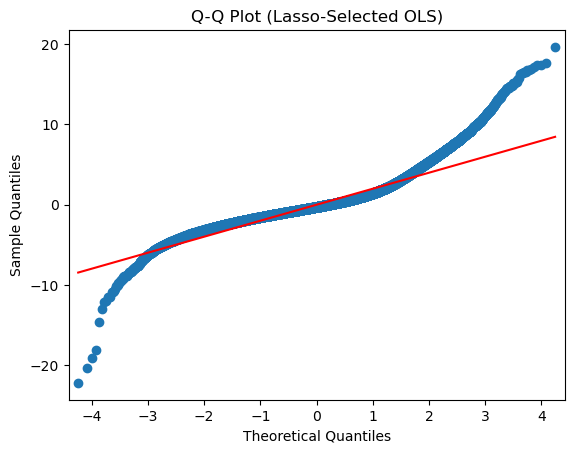

In [20]:
# 1) QQ plot
fig = sm.ProbPlot(resid).qqplot(line="s")
plt.title("Q-Q Plot (Lasso-Selected OLS)")
qq_ols_path = out_dir / "qq_lasso_ols.png"
plt.savefig(qq_ols_path, dpi=160)
plt.show()
plt.close()

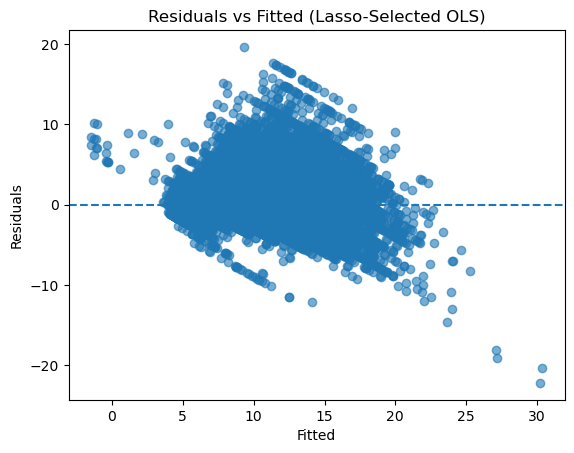

In [21]:
# 2) Residuals vs Fitted
plt.figure()
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted (Lasso-Selected OLS)")
rvf_ols_path = out_dir / "rvf_lasso_ols.png"
plt.savefig(rvf_ols_path, dpi=160)
plt.show()
plt.close()

In [22]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence

# 3) Breusch-Pagan
bp_stat, bp_p, _, _ = het_breuschpagan(resid, sm.add_constant(fitted))
# 4) Durbin-Watson
dw_stat = durbin_watson(resid)
# 5) Influence: Cook's distance vs leverage
infl = OLSInfluence(ols)
cooks = infl.cooks_distance[0]
leverage = infl.hat_matrix_diag

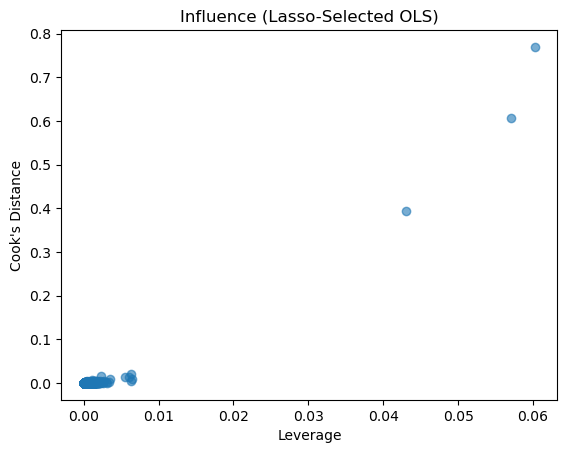

In [23]:
plt.figure()
plt.scatter(leverage, cooks, alpha=0.6)
plt.xlabel("Leverage"); plt.ylabel("Cook's Distance"); plt.title("Influence (Lasso-Selected OLS)")
influence_ols_path = out_dir / "influence_lasso_ols.png"
plt.savefig(influence_ols_path, dpi=160)
plt.show()
plt.close()


In [24]:
# Anderson-Darling (normality)
ad_stat, ad_p = normal_ad(resid)

# Build OLS table
ols_table = pd.DataFrame({
    "feature": ["Intercept"] + selected_features,
    "coef": ols.params.tolist(),
    "std_err": ols.bse.tolist(),
    "t": ols.tvalues.tolist(),
    "p_value": ols.pvalues.tolist()
})

C:\Users\alber\anaconda3\Lib\site-packages\statsmodels\stats\_adnorm.py:67: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


In [26]:
# ---------- Principal Components Regression (fast CV) ----------

from sklearn.metrics import make_scorer, mean_squared_error
# Fit preprocessor once
pre.fit(X)
X_all = pre.transform(X)
d = X_all.shape[1]

# PCA on all preprocessed features, randomized solver for speed
pca_full = PCA(random_state=42, svd_solver="randomized")
pca_full.fit(X_all)

# Choose K via quick 3-fold CV over a small candidate set
candidates = [k for k in [2,4,6,8,10] if 1 <= k <= d]
if not candidates:
    candidates = [min(2, d)]

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv3 = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_by_k = {}
for k in candidates:
    X_k = pca_full.transform(X_all)[:, :k]
    model = LinearRegression()
    scores = cross_val_score(model, X_k, y, scoring=rmse_scorer, cv=cv3)
    rmse_by_k[k] = -scores.mean()

best_k = min(rmse_by_k, key=rmse_by_k.get)
best_pcr_cv_rmse = rmse_by_k[best_k]

In [27]:
# Fit final PCR on full data
X_k_full = pca_full.transform(X_all)[:, :best_k]
pcr_lr = LinearRegression().fit(X_k_full, y)
pcr_fitted = pcr_lr.predict(X_k_full)
pcr_resid = y - pcr_fitted
pcr_resid

array([-0.03621701, -0.30087457,  1.68898545, ..., -0.83708184,
       -0.46536706,  0.52202214])

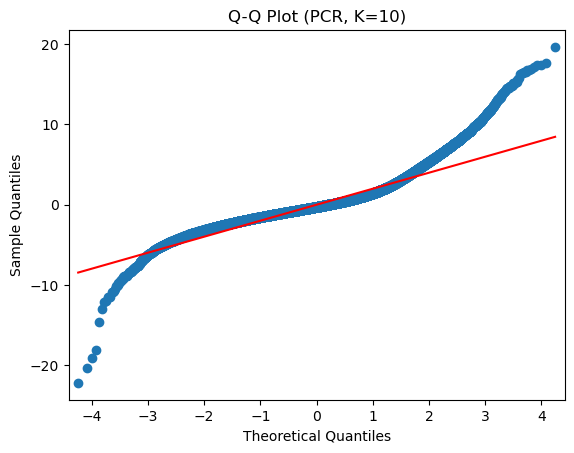

In [28]:
# PCR plots
fig = sm.ProbPlot(pcr_resid).qqplot(line="s")
plt.title(f"Q-Q Plot (PCR, K={best_k})")
qq_pcr_path = out_dir / f"qq_pcr_k{best_k}.png"
plt.savefig(qq_pcr_path, dpi=160);
plt.show()
plt.close()

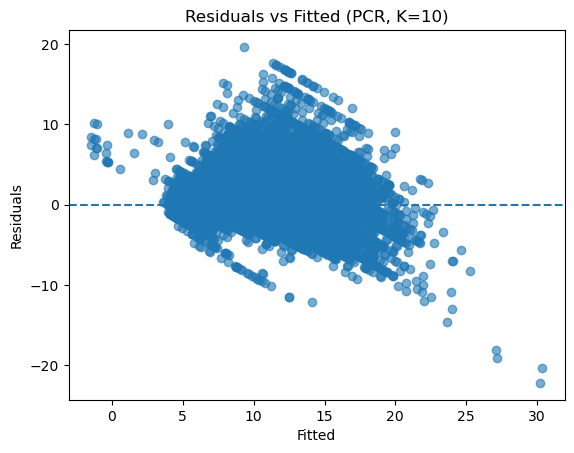

In [29]:
plt.figure()
plt.scatter(pcr_fitted, pcr_resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title(f"Residuals vs Fitted (PCR, K={best_k})")
rvf_pcr_path = out_dir / f"rvf_pcr_k{best_k}.png"
plt.savefig(rvf_pcr_path, dpi=160);plt.show()
plt.close()

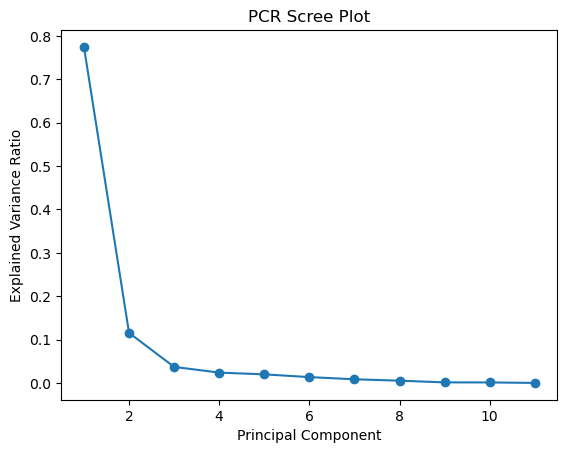

In [30]:
# Scree plot
explained = pca_full.explained_variance_ratio_
plt.figure()
plt.plot(np.arange(1, len(explained)+1), explained, marker="o")
plt.xlabel("Principal Component"); plt.ylabel("Explained Variance Ratio"); plt.title("PCR Scree Plot")
scree_path = out_dir / "pcr_scree.png"
plt.savefig(scree_path, dpi=160);plt.show()
plt.close()

In [31]:
# PCR summary tables
cum_explained = np.cumsum(explained)
k_table = pd.DataFrame({
    "n_components": candidates,
    "cv_rmse": [rmse_by_k[k] for k in candidates],
    "cum_variance_at_k": [float(cum_explained[k-1]) for k in candidates]
}).sort_values("n_components")
k_table

,n_components,cv_rmse,cum_variance_at_k
0,2,2.429871,0.890163
1,4,2.324273,0.950859
2,6,2.189759,0.984030
3,8,2.006581,0.997595
4,10,1.995594,1.000000


In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, make_scorer

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence

# Top loadings for interpretability (map PCs to original features)
# We'll take absolute loadings and show top 8 per PC among the first best_k PCs.
feature_names_full = get_feature_names(pre, num_cols, cat_cols)
components = pca_full.components_[:best_k, :]
loading_tables = []
for i in range(best_k):
    comp = components[i]
    abs_load = np.abs(comp)
    idx = np.argsort(-abs_load)[:8]  # top 8
    loading_tables.append(pd.DataFrame({
        "pc": [f"PC{i+1}"]*len(idx),
        "feature": [feature_names_full[j] if j < len(feature_names_full) else f"f{j}" for j in idx],
        "loading": comp[idx]
    }))

pcr_loadings = pd.concat(loading_tables, ignore_index=True)

In [33]:
# ---------- Build Kaggle submissions (optional but useful) ----------
# PCR submission
test_all = pre.transform(test)
test_pc = pca_full.transform(test_all)[:, :best_k]
test_preds_pcr = pcr_lr.predict(test_pc)

id_col = next((c for c in ["Id","ID","id"] if c in test.columns), None)
sub_pcr = pd.DataFrame({
    "Id": test[id_col] if id_col else np.arange(1, len(test_preds_pcr)+1),
    "Rings": test_preds_pcr
})
sub_pcr_path = out_dir / f"submission_pcr_{best_k}pc.csv"
sub_pcr.to_csv(sub_pcr_path, index=False)

# OLS (subset) submission (for comparison)
ols_preds = ols.predict(X_sel_const)
# For test, transform and slice same columns
test_trans = pre_fitted.transform(test)
test_sel = test_trans[:, selected_idx]
test_sel_const = sm.add_constant(test_sel, has_constant='add')
test_preds_ols = ols.predict(test_sel_const)

sub_ols = pd.DataFrame({
    "Id": test[id_col] if id_col else np.arange(1, len(test_preds_ols)+1),
    "Rings": test_preds_ols
})
sub_ols_path = out_dir / f"submission_lasso_subset_ols.csv"
sub_ols.to_csv(sub_ols_path, index=False)

# ---------- Display key tables to the user ----------
print("\n=== Lasso-selected OLS coefficients ===")
print(ols_table)

print("\n=== PCR CV (3-fold) across candidate components ===")
print(k_table)

print("\n=== PCR top loadings per PC (first K) ===")
print(pcr_loadings)




=== Lasso-selected OLS coefficients ===
           feature      coef   std_err           t        p_value
0        Intercept  9.949043  0.012010  828.427353   0.000000e+00
1               id -0.013647  0.006627   -2.059347   3.946390e-02
2           Length -0.245044  0.047421   -5.167366   2.379181e-07
3         Diameter  0.788905  0.048828   16.156777   1.229231e-58
4           Height  0.804212  0.018524   43.415387   0.000000e+00
5     Whole weight  1.726173  0.055143   31.303846  5.773750e-214
6   Whole weight.1 -3.231061  0.030701 -105.243786   0.000000e+00
7   Whole weight.2 -0.708320  0.029686  -23.860462  1.927650e-125
8     Shell weight  2.702671  0.028379   95.236264   0.000000e+00
9            Sex_F  0.014693  0.016770    0.876158   3.809465e-01
10           Sex_I -0.702469  0.019841  -35.405502  1.038791e-272

=== PCR CV (3-fold) across candidate components ===
   n_components   cv_rmse  cum_variance_at_k
0             2  2.429871           0.890163
1             4  2.32427